In [66]:
import os as os
import sys as sys
import subprocess
import k2
import subprocess
import matplotlib.pyplot as plt
from matplotlib import*
import numpy as np
import libcarma as libcarma
import time as time
import copy as copy
import math as math
import cmath as cmath
import psutil as psutil
%matplotlib inline

In [3]:
filePathVan = "/Users/Jackster/Desktop/k2c08AGN/Vanderberg/" 
filePathKT = "/Users/Jackster/Desktop/k2c08AGN/KTeam/" 
runbash = ['source ~/.bash_profile;']
subprocess.call(runbash, shell=True)
subprocess.call('export K2DATADIR="/Users/Jackster/Research/code/k2/data/k2c08AGN/Vanderberg/"',shell=True)
subprocess.call('source ~/Research/code/libcarma/bin/setup.sh',shell=True)


0

In [100]:
import seaborn as sns
sns.set_palette("colorblind")
sns.set_style("whitegrid")
def plotlc(t,y,mask):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.plot(t,y*mask, marker = '+')
    ax.set_xlabel('Time [days]')
    ax.set_ylabel('Flux')
    #ax.set_xlim(0, 6*np.pi)

In [102]:
LC = k2.k2LC(name = '220168966', band = 'Kep', processing = 'k2sff', campaign = 'c08')

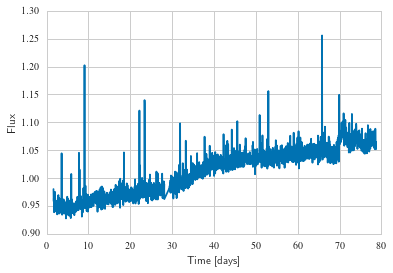

In [107]:
w = np.where(LC.mask == 1)[0]
fig1 = plotlc(LC.t[w],LC.y[w],LC.mask[w])
#plt.plot(LC.t,LC.y*LC.mask, 'k,')

In [112]:
def DHOparamsPlot(x,y):
    
    with sns.axes_style("darkgrid"):
        plt.hexbin(x, y,kind="hex",  cmap = "viridis")
        plt.xlim([0,30])
        plt.ylim([0,50])
        plt.colorbar()
    #with sns.axes_style("darkgrid"):
     #   sns.kdeplot(x, y,shade=False)    

In [108]:
# execute this cell
from sklearn.neighbors import KernelDensity
def kde_sklearn(data, grid, bandwidth = 1.0, **kwargs):
    kde_skl = KernelDensity(bandwidth = bandwidth, **kwargs)
    kde_skl.fit(data[:, np.newaxis])
    log_pdf = kde_skl.score_samples(grid[:, np.newaxis]) # sklearn returns log(density)

    return np.exp(log_pdf)

In [109]:
LC.minTimescale = 2.0
LC.maxTimescale = 0.5
LC.maxSigma = 2.0
pMax = 2
pMin = 2
qMin = 1
nwalkers = 200
nsteps = 2000
taskDict = dict()
DICDict= dict()

dataForResultsFile = [] 
for p in xrange(pMin, pMax + 1):

	for q in xrange(qMin, p):
		nt = libcarma.basicTask(p, q, nwalkers, nsteps)

		print 'Starting libcarma fitting for p = %d and q = %d...'%(p, q)
		startLCARMA = time.time()
		nt.fit(LC)
		stopLCARMA = time.time()
		timeLCARMA = stopLCARMA - startLCARMA
		print 'libcarma took %4.3f s = %4.3f min = %4.3f hrs'%(timeLCARMA, timeLCARMA/60.0, timeLCARMA/3600.0)

		Deviances = copy.copy(nt.LnPosterior[:,nsteps/2:]).reshape((-1))
		DIC = 0.5*math.pow(np.std(-2.0*Deviances),2.0) + np.mean(-2.0*Deviances)
		print 'C-ARMA(%d,%d) DIC: %+4.3e'%(p, q, DIC)
		DICDict['%d %d'%(p, q)] = DIC
		taskDict['%d %d'%(p, q)] = nt

Starting libcarma fitting for p = 2 and q = 1...
libcarma took 49.287 s = 0.821 min = 0.014 hrs
C-ARMA(2,1) DIC: +nan


In [84]:
np.shape(nt.Chain[:,:,:])

(4, 100, 250)

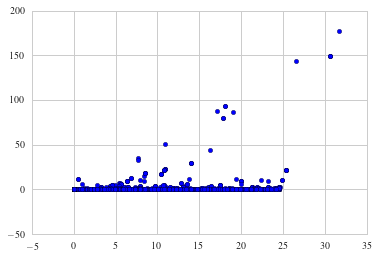

In [114]:

x1 = np.array(nt.Chain[0,:,:]).reshape((1,100*250))
x2 = np.array(nt.Chain[1,:,:]).reshape((1,100*250))
np.shape(x1)
plt.scatter(x1,x2)
#plt.xlim([0,30])
#plt.ylim([0,50])
#DHOparamsPlot(x1,x2)

In [ ]:
g = sns.PairGrid(iris, vars = ["sepal_length", "sepal_width", "petal_length", "petal_width"],
                 hue = "species", diag_sharey=False)
g.map_lower(sns.kdeplot)
g.map_upper(plt.scatter, edgecolor='white')
g.map_diag(sns.kdeplot, lw=3)